# Reservoir ensemble analysis

In [1]:
# ============================================================
# Glacier reservoir-function preprocessing (ensemble)
# FULL curated version with HISTORIC-GLACIER MASK
# Mirrors Reservoir_calculation.ipynb legacy logic
# Output: decomposed, deep-routed basin time series (m³/s)
# ============================================================

import glob
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pandas as pd
import xarray as xr
from scipy.special import gamma

# ----------------------------
# 0. USER PATHS / SETTINGS
# ----------------------------

ROOT_JULES   = Path("/home/clara/project/NbS/jules-output")   # NetCDF outputs per scen/model
ROOT_VOLUME  = Path("/home/clara/rahu_data/JULES_OGGM/cmip_runs_combined_v3")  # volume CSVs
AREA_PATH    = Path("/home/clara/rahu_data/netcdf/gridcell_area_km105.nc")
HYD_COND_PATH= Path("/home/jec18/gis_layer/groundwater/hydrogeo_k.nc")
CROPPING_PATH= ROOT_VOLUME / "latlon_392.csv"

SCENARIOS = ["rcp45", "rcp85"]

# Baseline historic file used for:
# (1) historic with glaciers
# (2) historic no-glacier
# and as climate baseline for pseudo-futures
HIST_BASE_SCEN  = "rcp45"
HIST_BASE_MODEL = "ACCESS1-0"
HIST_BASE_NETCDF= ROOT_JULES / HIST_BASE_SCEN / HIST_BASE_MODEL / \
                  f"{HIST_BASE_SCEN}_{HIST_BASE_MODEL}_degradation_coupled_jules_oggm_00_99.nc"

# Time windows
HIST_LOAD_START, HIST_LOAD_END     = "2000-01-01", "2018-12-31"
HIST_SERIES_START, HIST_SERIES_END = "2002-01-01", "2018-12-31"

FUT_LOAD_START, FUT_LOAD_END       = "2081-01-01", "2099-12-31"
FUT_SERIES_START, FUT_SERIES_END   = "2083-01-01", "2099-12-31"

rho = 1000.0  # kg m-3
SECONDS_PER_DAY = 24 * 3600

# Nash unit hydrograph parameters (legacy)
k0 = 18.59720523
n0 = 22.57835457
V  = 1.0

COMPONENT_VARS = ["surface", "melt", "shallow_subsurface", "deep_subsurface"]

# ----------------------------
# 1. LOAD STATIC FIELDS
# ----------------------------

grid_area = xr.open_dataset(AREA_PATH).area
grid_area = grid_area.where(grid_area > 0)
if "time" in grid_area.dims:
    grid_area = grid_area.isel(time=0, drop=True)

# Catchment mask (all valid basin cells)
basin_mask = grid_area.notnull()

# Hydraulic conductivity (legacy split)
hyd_cond = xr.open_dataset(HYD_COND_PATH).Band1.fillna(0)
hyd_cond = hyd_cond.interp(lat=grid_area.lat, lon=grid_area.lon, kwargs={"fill_value": 0})

# ----------------------------
# 2. LOAD HISTORIC BASELINE EARLY + DEFINE HISTORIC GLACIER MASK
# ----------------------------

def normalize_dims(ds: xr.Dataset) -> xr.Dataset:
    rename = {}
    if "latitude" in ds.dims:  rename["latitude"] = "lat"
    if "longitude" in ds.dims: rename["longitude"] = "lon"
    if rename:
        ds = ds.rename(rename)
    return ds


historic_base = xr.open_dataset(HIST_BASE_NETCDF)[["melt","surf_roff","sub_surf_roff","area","perc"]]
historic_base = normalize_dims(historic_base).sel(time=slice(HIST_LOAD_START, HIST_LOAD_END))
historic_base = historic_base.where(basin_mask)

# HISTORIC glacier analysis mask:
# only cells inside basin AND with glacier area > 0 at first historic timestep
hist0_area = historic_base["perc"].isel(time=0)
analysis_mask = basin_mask & (hist0_area > 0)
analysis_mask.name = "analysis_mask"

historic_base = historic_base.where(analysis_mask)


print("Historically glacierized cells:", int(analysis_mask.sum()))

# Use this for all volumetric conversions
component_grid_area = grid_area.where(analysis_mask, 0.0)


Historically glacierized cells: 80


In [2]:

# ----------------------------
# 3. SMALL UTILITIES
# ----------------------------

def _broadcast_static(static_da, target_da):
    """Expand a 2-D static field to match a time-dependent target for array math."""
    return xr.broadcast(static_da, target_da)[0]

def _flux_to_volume_series(flux_da):
    return ((flux_da / rho) * component_grid_area).sum(dim=("lat", "lon"))

def align_dayofyear(source: xr.DataArray, target_time: xr.DataArray) -> xr.DataArray:
    """Map future daily field onto target time axis using DOY climatology."""
    clim = source.groupby("time.dayofyear").mean("time")
    aligned = clim.sel(dayofyear=target_time.dt.dayofyear)
    return aligned.assign_coords(time=target_time).drop_vars("dayofyear")

# ----------------------------
# 4. UNIT HYDROGRAPH ROUTING 
# ----------------------------

def unit_hydro(V,k,n,t,er):
    from scipy.special import gamma
    import numpy as np
    from scipy.sparse import spdiags

    #inputs
    # V = volume of unit hydrograph
    # k,n = parameters from Nash (1957)
    # t = unit hydrograph time
    # er = effective rainfall time-series
    
    # outputs
    # DGW = deeper groundwater flow
    # uh = unit hydrograph
    
    uh = np.array(V/(k*gamma(n))*np.multiply(np.exp(-t/k),np.power((t/k),n-1)))
    uh = uh/np.sum(uh)
    
    # from Ana Mijic as from Anthony script
    m = er.size
    r = t.size
    n = r+m-1
    
    pmat = spdiags(np.multiply(np.ones(r),np.row_stack(er)),np.arange(0,-er.size,-1),n,r)
    
    DGW = pmat*uh
    DGW = DGW[0:er.size]
    
    return [DGW, uh]

def route_component(series):
    """Convolve a 1-D flow series with the pre-defined unit hydrograph."""
    routed, _ = unit_hydro(V, k0, n0, np.arange(series.sizes["time"]), series.values)
    return xr.DataArray(routed, coords=series.coords, dims=series.dims, name=series.name)

# ----------------------------
# 5. CORE PREPROCESSING LOGIC
# ----------------------------

def remove_surface_melt(ds: xr.Dataset):
    non_glacier_fraction = (1 - ds["perc"]).clip(min=0)
    melt_vol = (ds["melt"] / rho) * component_grid_area
    surface_vol = (ds["surf_roff"] / rho) * component_grid_area
    rain_vol = (surface_vol - melt_vol).clip(min=0.0)
    rain_flux = xr.where(component_grid_area > 0, rain_vol / component_grid_area, 0.0)
    rain_flux_exposed = xr.where(non_glacier_fraction > 0, rain_flux / non_glacier_fraction, 0.0)
    cleaned = ds.copy(deep=True)
    cleaned["surf_roff"] = rain_flux * rho
    return cleaned, rain_flux_exposed, non_glacier_fraction


def build_no_glacier_dataset(ds_cleaned,
                             rain_flux_exposed,
                             non_glacier_fraction):
    """
    Legacy no-glacier:
      - melt=0, area=0, perc=0
      - surface = rain_flux_exposed applied over full cell (kg/m2/s)
      - subsurface scaled by 1/non_glacier_fraction
    """
    ds_cleaned = ds_cleaned.where(analysis_mask, 0.0)
    rain_flux_exposed = rain_flux_exposed.where(analysis_mask, 0.0)
    non_glacier_fraction = non_glacier_fraction.where(analysis_mask, 1.0)

    result = ds_cleaned.copy(deep=True)
    result["melt"] = 0.0 * ds_cleaned["melt"]
    result["area"] = 0.0 * ds_cleaned["area"]
    result["perc"] = xr.zeros_like(ds_cleaned["perc"])

    result["surf_roff"] = rain_flux_exposed * rho

    subsurface_scale = xr.where(non_glacier_fraction > 0,
                                1.0 / non_glacier_fraction,
                                0.0)
    result["sub_surf_roff"] = ds_cleaned["sub_surf_roff"] * subsurface_scale
    return result


def build_pseudo_future(hist_cleaned,
                        fut_area_aligned,
                        volume_ratio_arr,
                        rain_flux_hist_exposed,
                        non_glacier_fraction_hist):
    """
    Legacy pseudo-future:
      - climate = historic
      - future area/perc mapped onto historic dates
      - melt scaled by volume_ratio
      - rain runoff redistributed over new exposed area
      - subsurface scaled by exposed-area ratio
    """
    hist_cleaned = hist_cleaned.where(analysis_mask, 0.0)
    fut_area_aligned = fut_area_aligned.where(analysis_mask, 0.0)

    pseudo = hist_cleaned.copy(deep=True)

    future_area = fut_area_aligned.clip(min=0.0, max=component_grid_area)
    future_area = xr.where(future_area < hist_cleaned["area"],
                           future_area,
                           hist_cleaned["area"])

    pseudo["area"] = future_area
    future_perc = (future_area / component_grid_area).clip(min=0.0, max=1.0)
    pseudo["perc"] = future_perc

    pseudo["melt"] = hist_cleaned["melt"] * volume_ratio_arr

    non_glacier_fraction_fut = (1.0 - future_perc).clip(min=1e-6)

    pseudo["surf_roff"] = (rain_flux_hist_exposed * non_glacier_fraction_fut) * rho

    scale = xr.where(non_glacier_fraction_hist > 0,
                     non_glacier_fraction_fut / non_glacier_fraction_hist,
                     0.0)
    pseudo["sub_surf_roff"] = hist_cleaned["sub_surf_roff"] * scale

    return pseudo


def split_runoff_components(ds):
    """Return timeseries (m3/s) for each runoff component in dataset ds."""
    hyd_cond_time = _broadcast_static(hyd_cond* 1000.0, ds["sub_surf_roff"]) 
    deep_flux = xr.apply_ufunc(np.minimum, ds["sub_surf_roff"], hyd_cond_time)
    shallow_flux = (ds["sub_surf_roff"] - deep_flux).clip(min=0.0)
    
    components = xr.Dataset({
        "surface": _flux_to_volume_series(ds["surf_roff"]),
        "melt": _flux_to_volume_series(ds["melt"]),
        "shallow_subsurface": _flux_to_volume_series(shallow_flux),
        "deep_subsurface": _flux_to_volume_series(deep_flux),
    })
    components["total"] = components[COMPONENT_VARS].to_array("component").sum("component")
    return components

def build_component_timeseries(ds):
    raw = split_runoff_components(ds)
    routed = raw.copy(deep=True)
    routed["deep_subsurface"] = route_component(raw["deep_subsurface"])
    routed["total"] = (
        routed["surface"]
        + routed["melt"]
        + routed["shallow_subsurface"]
        + routed["deep_subsurface"]
    )
    return {"raw": raw, "uh": routed}

# ----------------------------
# 6. VOLUME RATIO MAP (CSV)
# ----------------------------

cropping = pd.read_csv(CROPPING_PATH)

def discover_volume_files():
    per_model_map = {scen: {} for scen in SCENARIOS}
    for scen in SCENARIOS:
        pattern = str(ROOT_VOLUME  / f"{scen}_*_volume*.csv")
        files = sorted(Path(p) for p in glob.glob(pattern))
        for f in files:
            stem = f.stem
            if not stem.startswith(scen + "_"):
                continue
            model_part = stem[len(scen) + 1:]
            if "_volume" in model_part:
                model_part = model_part.split("_volume")[0]
            per_model_map[scen][model_part] = f
    return per_model_map

def load_volume_ratio(volume_file: Path,
                      cropping_df: pd.DataFrame,
                      hist_years=(2002, 2018),
                      fut_years=(2083, 2099)) -> float:
    raw = pd.read_csv(volume_file)
    ids = set(cropping_df["RGI_ID"].astype(str))

    year_col = "Unnamed: 0"
    cols = [year_col] + [c for c in raw.columns if c in ids]
    df = raw.loc[:, cols].copy()

    years = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")
    df = df.loc[years.notna()].copy()
    df["year"] = years.loc[years.notna()].astype(int)
    df = df.drop(columns=[year_col]).set_index(pd.to_datetime(df["year"], format="%Y"))
    df = df.drop(columns=["year"])

    total = df.sum(axis=1)

    hist_mask = (total.index.year >= hist_years[0]) & (total.index.year <= hist_years[1])
    fut_mask  = (total.index.year >= fut_years[0])  & (total.index.year <= fut_years[1])

    hist_mean = total.loc[hist_mask].mean()
    fut_mean  = total.loc[fut_mask].mean()

    if hist_mean <= 0:
        return 0.0
    return float(fut_mean / hist_mean)

def build_volume_ratio_map(volume_map):
    ratios = {scen: {} for scen in SCENARIOS}
    for scen in SCENARIOS:
        for model, f in volume_map[scen].items():
            ratios[scen][model] = load_volume_ratio(f, cropping)
    return ratios

# ----------------------------
# 7. DISCOVER NETCDFS
# ----------------------------

def discover_netcdfs():
    per_scen = {scen: [] for scen in SCENARIOS}
    for scen in SCENARIOS:
        pattern = str(ROOT_JULES / scen / "*" / f"{scen}_*_degradation_coupled_jules_oggm_00_99.nc")
        per_scen[scen] = sorted(Path(p) for p in glob.glob(pattern))
    return per_scen

# ----------------------------
# 8. PER-MODEL PROCESSOR
# ----------------------------

def process_model_future_and_pseudo(scen, path,
                                    hist_cleaned_base,
                                    rain_flux_hist_exposed,
                                    non_glacier_fraction_hist,
                                    vol_ratio_scalar):
    model = path.parent.name

    # --- FUTURE WITH GLACIERS ---
    fut = xr.open_dataset(path)[["melt","surf_roff","sub_surf_roff","area","perc"]]
    fut = normalize_dims(fut).sel(time=slice(FUT_LOAD_START, FUT_LOAD_END))
    fut = fut.where(analysis_mask)

    fut_cleaned, rain_flux_fut_exposed, non_glacier_fraction_fut = remove_surface_melt(fut)
    fut_ts = build_component_timeseries(fut_cleaned)

    # --- FUTURE NO GLACIERS ---
    fut_no_glac = build_no_glacier_dataset(fut_cleaned,
                                          rain_flux_fut_exposed,
                                          non_glacier_fraction_fut)
    fut_no_glac_ts = build_component_timeseries(fut_no_glac)

    # --- PSEUDO-FUTURE ON HISTORIC CLIMATE ---
    fut_area_aligned = align_dayofyear(fut_cleaned["area"], hist_cleaned_base.time)
    fut_area_aligned = fut_area_aligned.where(analysis_mask)

    volume_ratio_arr = xr.full_like(hist_cleaned_base["area"], float(vol_ratio_scalar))

    pseudo = build_pseudo_future(hist_cleaned_base,
                                 fut_area_aligned,
                                 volume_ratio_arr,
                                 rain_flux_hist_exposed,
                                 non_glacier_fraction_hist)
    pseudo_ts = build_component_timeseries(pseudo)

    return {
        "scenario": scen,
        "model": model,
        "future": fut_ts,
        "future_no_glacier": fut_no_glac_ts,
        "pseudo_future": pseudo_ts,
    }

# ----------------------------
# 9. BUILD HISTORIC (1) AND HISTORIC NO-GLACIER (2)
# ----------------------------

historic_cleaned, rain_flux_hist_exposed, non_glacier_fraction_hist = remove_surface_melt(historic_base)

historic_ts = build_component_timeseries(historic_cleaned)

historic_no_glacier = build_no_glacier_dataset(historic_cleaned,
                                              rain_flux_hist_exposed,
                                              non_glacier_fraction_hist)
historic_no_glacier_ts = build_component_timeseries(historic_no_glacier)

print("Built historic and historic_no_glacier component series.")

Built historic and historic_no_glacier component series.


In [3]:
# ----------------------------
# 10. ENSEMBLE RUN (3)-(5)
# ----------------------------

netcdf_files = discover_netcdfs()
volume_map = discover_volume_files()
volume_ratios = build_volume_ratio_map(volume_map)
ensemble_results = []

with ThreadPoolExecutor(max_workers=6) as ex:
    futures = []
    for scen in SCENARIOS:
        for path in netcdf_files[scen]:
            model = path.parent.name
            vr = volume_ratios.get(scen, {}).get(model, 1.0)

            futures.append(
                ex.submit(
                    process_model_future_and_pseudo,
                    scen, path,
                    hist_cleaned_base=historic_cleaned,
                    rain_flux_hist_exposed=rain_flux_hist_exposed,
                    non_glacier_fraction_hist=non_glacier_fraction_hist,
                    vol_ratio_scalar=vr
                )
            )

    for f in as_completed(futures):
        res = f.result()
        ensemble_results.append(res)
        print(f"Done {res['scenario']} / {res['model']} (vr={volume_ratios[res['scenario']].get(res['model'], np.nan):.3f})")

print(f"Ensemble complete: {len(ensemble_results)} model runs.")

# ----------------------------
# 11. FINAL OUTPUTS
# ----------------------------
# (1) historic with glaciers:
#     historic_ts["uh"]  -> Dataset(surface, melt, shallow_subsurface, deep_subsurface, total)
# (2) historic no glaciers:
#     historic_no_glacier_ts["uh"]
# (3) historic climate with future extent (pseudo futures):
#     for res in ensemble_results: res["pseudo_future"]["uh"]
# (4) future with glaciers:
#     for res in ensemble_results: res["future"]["uh"]
# (5) future no glaciers:
#     for res in ensemble_results: res["future_no_glacier"]["uh"]


Done rcp45 / CESM1-CAM5 (vr=0.272)
Done rcp45 / CCSM4 (vr=0.301)
Done rcp45 / BNU-ESM (vr=0.248)
Done rcp45 / ACCESS1-3 (vr=0.157)
Done rcp45 / CESM1-BGC (vr=0.313)
Done rcp45 / ACCESS1-0 (vr=0.182)
Done rcp45 / CMCC-CMS (vr=0.162)
Done rcp45 / CMCC-CM (vr=0.176)
Done rcp45 / CSIRO-Mk3-6-0 (vr=0.101)
Done rcp45 / CanESM2 (vr=0.238)
Done rcp45 / GFDL-CM3 (vr=0.081)
Done rcp45 / CNRM-CM5 (vr=0.171)
Done rcp45 / GFDL-ESM2M (vr=0.204)
Done rcp45 / GFDL-ESM2G (vr=0.213)
Done rcp45 / FGOALS-g2 (vr=0.321)
Done rcp45 / HadGEM2-ES (vr=0.197)
Done rcp45 / IPSL-CM5A-LR (vr=0.175)
Done rcp45 / HadGEM2-CC (vr=0.218)
Done rcp45 / IPSL-CM5B-LR (vr=0.223)
Done rcp45 / MIROC-ESM-CHEM (vr=0.223)
Done rcp45 / MIROC5 (vr=0.274)
Done rcp45 / IPSL-CM5A-MR (vr=0.141)
Done rcp45 / MPI-ESM-MR (vr=0.191)
Done rcp45 / MIROC-ESM (vr=0.184)
Done rcp45 / MPI-ESM-LR (vr=0.201)
Done rcp45 / MRI-CGCM3 (vr=0.300)
Done rcp45 / NorESM1-M (vr=0.276)
Done rcp45 / bcc-csm1-1-m (vr=0.306)
Done rcp85 / ACCESS1-3 (vr=0.060)
Do

In [4]:
ensemble_results

[{'scenario': 'rcp45',
  'model': 'CESM1-CAM5',
  'future': {'raw': <xarray.Dataset> Size: 333kB
   Dimensions:             (time: 6939)
   Coordinates:
     * time                (time) datetime64[ns] 56kB 2081-01-01 ... 2099-12-31
       spatial_ref         int64 8B 0
   Data variables:
       surface             (time) float64 56kB 1.709 1.079 3.375 ... 6.794 10.59
       melt                (time) float64 56kB 6.705 7.129 6.528 ... 3.124 2.486
       shallow_subsurface  (time) float64 56kB 10.94 9.911 9.251 ... 13.61 14.46
       deep_subsurface     (time) float64 56kB 11.57 10.69 10.41 ... 10.32 11.29
       total               (time) float64 56kB 30.93 28.81 29.56 ... 33.85 38.83,
   'uh': <xarray.Dataset> Size: 333kB
   Dimensions:             (time: 6939)
   Coordinates:
     * time                (time) datetime64[ns] 56kB 2081-01-01 ... 2099-12-31
       spatial_ref         int64 8B 0
   Data variables:
       surface             (time) float64 56kB 1.709 1.079 3.375 ... 6.79

Total pseudo-futures: 60
RCP4.5 pseudo-futures: 30
RCP8.5 pseudo-futures: 30


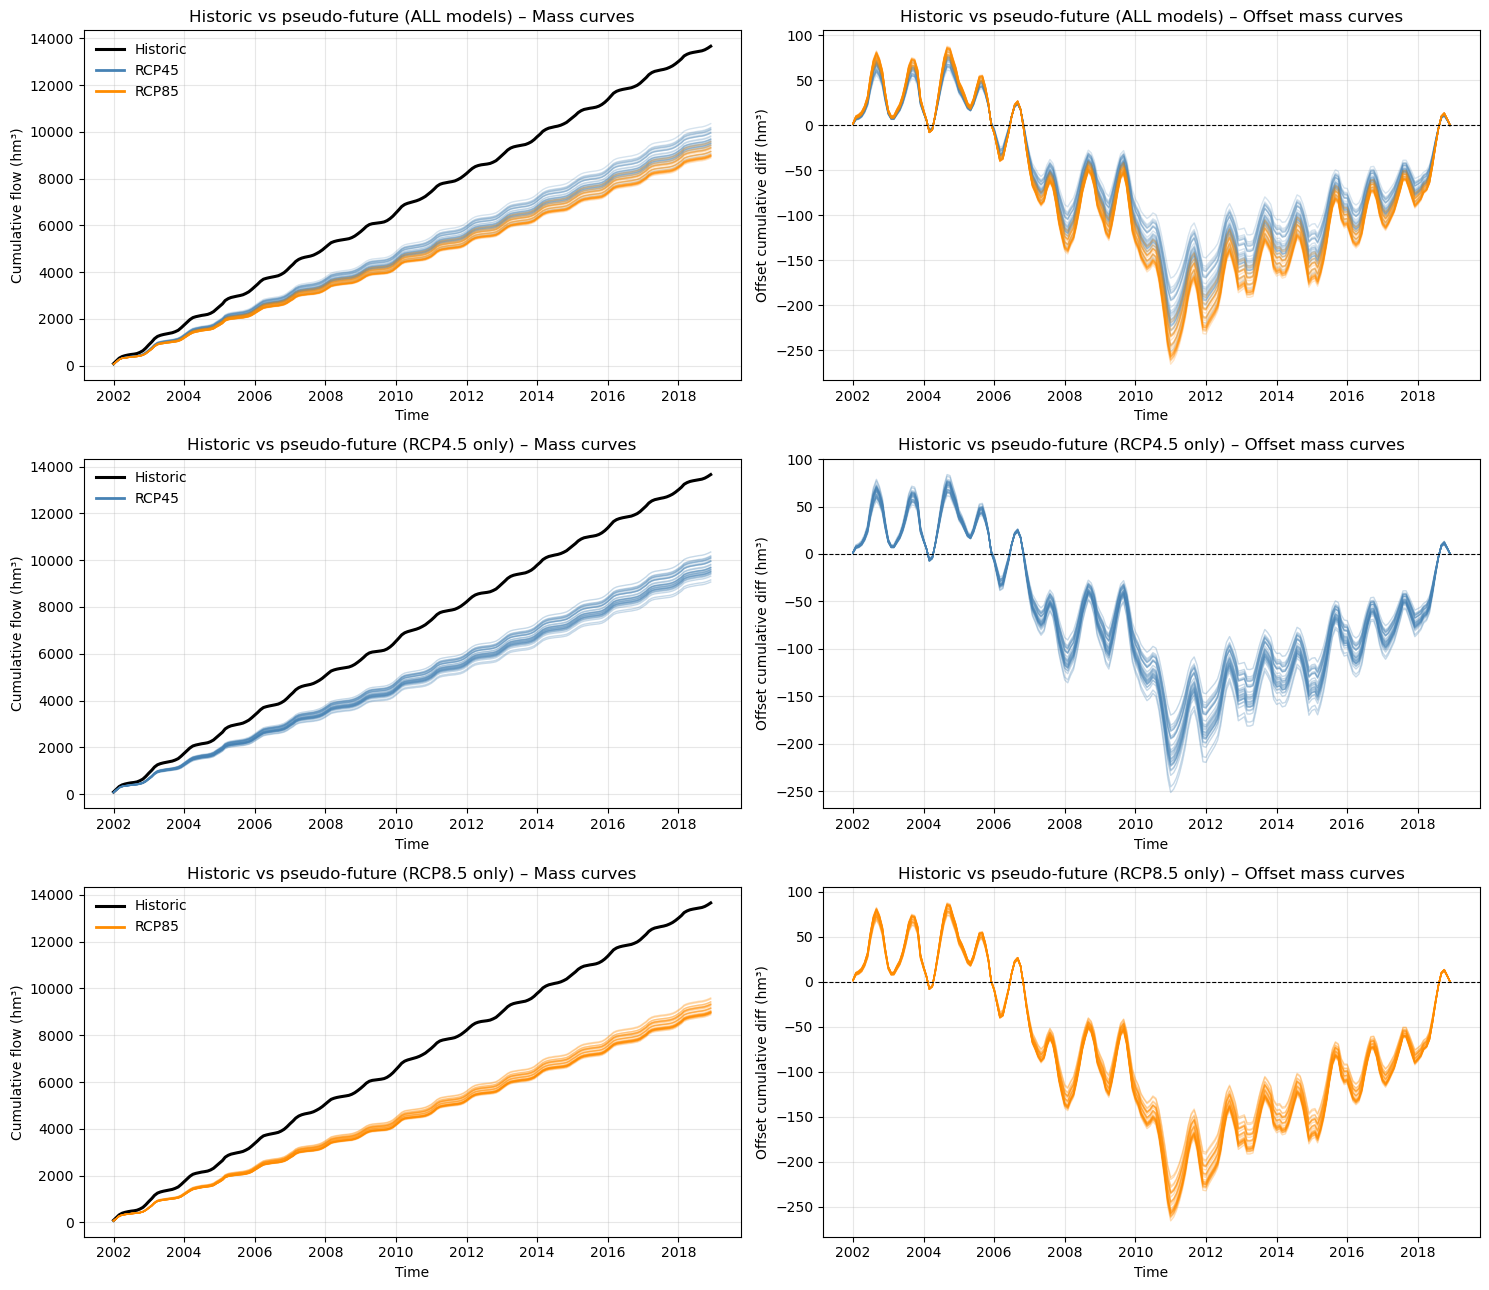

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

SECONDS_PER_DAY = globals().get("SECONDS_PER_DAY", 24 * 3600)

# ----------------------------
# Helpers
# ----------------------------
def get_historic_uh_total():
    # prefer your new objects if present
    if "historic_ts" in globals():
        return historic_ts["uh"]["total"]

def monthly_volume(series, start, end):
    window = series.sel(time=slice(start, end))
    monthly = window.resample(time="MS").mean()
    # hm3 per month
    volumes_hm3 = (monthly * monthly["time"].dt.days_in_month * SECONDS_PER_DAY) / 1e6
    return volumes_hm3

def compute_mass_and_offset(base_series, comp_series, start, end):
    base_vol = monthly_volume(base_series, start, end)
    comp_vol = monthly_volume(comp_series, start, end).reindex(time=base_vol["time"], method=None)

    combined = xr.Dataset({"base": base_vol, "compare": comp_vol}).dropna("time", how="any")
    base_vol = combined["base"]
    comp_vol = combined["compare"]

    cum_base = base_vol.cumsum(dim="time")
    cum_comp = comp_vol.cumsum(dim="time")

    diff = (comp_vol - base_vol)
    mean_diff = diff.mean().item()
    offset_curve = (diff - mean_diff).cumsum(dim="time")

    return cum_base, cum_comp, offset_curve, mean_diff

def plot_group(ax_mass, ax_off, results, title, start, end,
               color_map={"rcp45": "steelblue", "rcp85": "darkorange"},
               alpha_lines=0.25):

    base_series = get_historic_uh_total()
    # base cumulative once
    cum_base = monthly_volume(base_series, start, end).cumsum("time")
    ax_mass.plot(cum_base["time"].values, cum_base.values,
                 color="black", linewidth=2.2, label="Historic cumulative")

    # overlay pseudo-futures
    for res in results:
        scen = res["scenario"]
        model = res["model"]
        comp_series = res["pseudo_future"]["uh"]["total"]

        cum_b, cum_c, offset_c, mean_diff = compute_mass_and_offset(
            base_series, comp_series, start, end
        )

        ax_mass.plot(cum_c["time"].values, cum_c.values,
                     color=color_map.get(scen, "grey"),
                     alpha=alpha_lines, linewidth=1.0)

        ax_off.plot(offset_c["time"].values, offset_c.values,
                    color=color_map.get(scen, "grey"),
                    alpha=alpha_lines, linewidth=1.0)

    # cosmetics
    ax_mass.set_title(f"{title} – Mass curves")
    ax_mass.set_ylabel("Cumulative flow (hm³)")
    ax_mass.grid(alpha=0.3)

    ax_off.set_title(f"{title} – Offset mass curves")
    ax_off.axhline(0, color="black", linewidth=0.8, linestyle="--")
    ax_off.set_ylabel("Offset cumulative diff (hm³)")
    ax_off.grid(alpha=0.3)

    # legend only for scenario colors + historic
    from matplotlib.lines import Line2D
    legend_elems = [Line2D([0],[0], color="black", lw=2.2, label="Historic")]
    for scen, col in color_map.items():
        legend_elems.append(Line2D([0],[0], color=col, lw=2, label=scen.upper()))
    ax_mass.legend(handles=legend_elems, frameon=False)


# ----------------------------
# Build the three groups
# ----------------------------
start, end = "2002-01-01", "2018-12-31"

all_results   = ensemble_results
rcp45_results = [r for r in ensemble_results if r["scenario"] == "rcp45"]
rcp85_results = [r for r in ensemble_results if r["scenario"] == "rcp85"]

# sanity check
print("Total pseudo-futures:", len(all_results))
print("RCP4.5 pseudo-futures:", len(rcp45_results))
print("RCP8.5 pseudo-futures:", len(rcp85_results))

# ----------------------------
# 3 pairs of plots (3x2 figure)
# ----------------------------
fig, axes = plt.subplots(3, 2, figsize=(15, 13), sharex=False)
axes = np.atleast_2d(axes)

plot_group(axes[0,0], axes[0,1], all_results,
           "Historic vs pseudo-future (ALL models)", start, end,
           alpha_lines=0.22)

plot_group(axes[1,0], axes[1,1], rcp45_results,
           "Historic vs pseudo-future (RCP4.5 only)", start, end,
           color_map={"rcp45": "steelblue"}, alpha_lines=0.30)

plot_group(axes[2,0], axes[2,1], rcp85_results,
           "Historic vs pseudo-future (RCP8.5 only)", start, end,
           color_map={"rcp85": "darkorange"}, alpha_lines=0.30)

for r in range(3):
    axes[r,0].set_xlabel("Time")
    axes[r,1].set_xlabel("Time")

fig.tight_layout()
plt.show()


In [6]:
import numpy as np
import pandas as pd
import xarray as xr

SECONDS_PER_DAY = globals().get("SECONDS_PER_DAY", 24 * 3600)

# ---------- helpers (same as before) ----------
def get_historic_uh_total():
    if "historic_ts" in globals():
        return historic_ts["uh"]["total"]

def monthly_volume(series, start, end):
    window = series.sel(time=slice(start, end))
    monthly = window.resample(time="MS").mean()
    volumes_hm3 = (monthly * monthly["time"].dt.days_in_month * SECONDS_PER_DAY) / 1e6
    return volumes_hm3

def compute_offset_curve(base_series, comp_series, start, end):
    base_vol = monthly_volume(base_series, start, end)
    comp_vol = monthly_volume(comp_series, start, end).reindex(time=base_vol["time"], method=None)

    combined = xr.Dataset({"base": base_vol, "compare": comp_vol}).dropna("time", how="any")
    base_vol = combined["base"]
    comp_vol = combined["compare"]

    diff = (comp_vol - base_vol)
    mean_diff = diff.mean().item()
    offset_curve = (diff - mean_diff).cumsum(dim="time")  # EXACT legacy

    return offset_curve

def metrics_from_offset(offset_curve: xr.DataArray):
    """
    Replicates your notebook logic:
      global_range = max-min of offset curve
      local_peak_to_trough = max drop from local peak to following trough
    """
    s = offset_curve.to_series().dropna()

    if s.empty:
        return np.nan, np.nan

    global_range = s.max() - s.min()

    # local extrema
    peaks = s[(s.shift(1) < s) & (s.shift(-1) <= s)]
    troughs = s[(s.shift(1) > s) & (s.shift(-1) >= s)]

    local_drop = None
    for peak_time, peak_val in peaks.items():
        future_troughs = troughs[troughs.index > peak_time]
        if future_troughs.empty:
            continue
        trough_val = future_troughs.iloc[0]
        drop = peak_val - trough_val
        if (local_drop is None) or (drop > local_drop):
            local_drop = drop

    if local_drop is None:
        local_drop = 0.0

    return float(global_range), float(local_drop)

# ---------- main loop ----------
start, end = "2002-01-01", "2018-12-31"
base_series = get_historic_uh_total()

rows = []
for res in ensemble_results:
    scen  = res["scenario"]   # "rcp45" / "rcp85"
    model = res["model"]
    comp_series = res["pseudo_future"]["uh"]["total"]

    offset_curve = compute_offset_curve(base_series, comp_series, start, end)
    global_range, local_drop = metrics_from_offset(offset_curve)

    rows.append({
        "scenario": scen,
        "model": model,
        "global_range_hm3": global_range,
        "local_peak_to_trough_hm3": local_drop
    })

metrics_df = pd.DataFrame(rows)
metrics_df


,scenario,model,global_range_hm3,local_peak_to_trough_hm3
0,rcp45,CESM1-CAM5,263.088376,90.189806
1,rcp45,CCSM4,252.417106,86.516333
2,rcp45,BNU-ESM,272.390410,93.198757
3,rcp45,ACCESS1-3,305.963613,103.693562
4,rcp45,CESM1-BGC,247.785999,85.027027
5,rcp45,ACCESS1-0,297.016126,100.951446
6,rcp45,CMCC-CMS,304.527066,103.069652
7,rcp45,CMCC-CM,299.513504,101.304791
8,rcp45,CSIRO-Mk3-6-0,327.255985,109.832687
9,rcp45,CanESM2,277.357619,94.368068


In [7]:
def q1(x): return x.quantile(0.25)
def q3(x): return x.quantile(0.75)

summary_df = (
    metrics_df
    .groupby("scenario")[["global_range_hm3", "local_peak_to_trough_hm3"]]
    .agg(["median", q1, q3])
)

summary_df.columns = ["_".join([var, stat if isinstance(stat,str) else stat.__name__])
                      for var, stat in summary_df.columns]

summary_df


,global_range_hm3_median,global_range_hm3_q1,global_range_hm3_q3,local_peak_to_trough_hm3_median,local_peak_to_trough_hm3_q1,local_peak_to_trough_hm3_q3
scenario,,,,,,
rcp45,284.792732,261.580227,298.291572,97.018742,89.902485,101.216454
rcp85,333.914379,313.428762,342.832725,112.378462,106.061848,114.459114
